In [9]:
import xarray as xr # for data handling
import numpy as np # for maths
import matplotlib as mpl # plotlibrary
import matplotlib.pyplot as plt # for the plots 
from matplotlib.patches import Rectangle
from matplotlib.colors import LogNorm # for making a log 10 colorscale
import cartopy # library for making maps
from cartopy import crs as ccrs # Projection Library
from cartopy.crs import Stereographic, PlateCarree, Mollweide # Map projections I use00
from cartopy.feature import LAND, COASTLINE # Vectordata of the Coastline and land for making the maps prettier
import cmocean
from glob import glob
import dask
from scipy.io import loadmat
import gsw

# Exercise 1

In [10]:
def deg360to180(ds, lon_dim):
    dim_name = ds[lon_dim].dims[0]
    ds["lon_new"] = xr.where(
    ds[lon_dim]>180, # take all the values, where X is less than zero
    ds[lon_dim]-360, # if true, add 360
    ds[lon_dim], # if false take them verbatim
    )
    ds = (
        ds
        .swap_dims(dict(zip([dim_name], ["lon_new"]))) # Make the new values to our dimension
        .sortby("lon_new") # make sure to sort them
        .drop_vars(lon_dim) # drop the old Dimension
        .rename(dict(zip(["lon_new"],[dim_name])))
    )#
    return ds

## Read Files

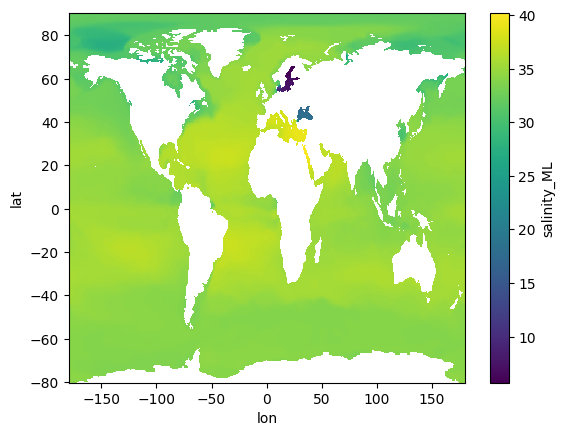

In [11]:
mimoc_files = glob("./MIMOC_ML_v2.2_PT_S/*")
mimoc = xr.open_mfdataset(mimoc_files, combine="nested", concat_dim="month", compat="no_conflicts", data_vars="different")
mimoc = mimoc.assign_coords(
    dict(
        lat=mimoc.LATITUDE,
        lon=mimoc.LONGITUDE,
    )
).swap_dims(
    dict(
        LAT="lat",
        LONG="lon",
    )
).drop_vars(("LATITUDE", "LONGITUDE")).sortby(["lon", "lat"])
mimoc = deg360to180(mimoc, "lon")
mimoc = mimoc.rename_vars(
    dict(
        SALINITY_MIXED_LAYER="salinity_ML",
        POTENTIAL_TEMPERATURE_MIXED_LAYER="pot_temp_ML",
        DEPTH_MIXED_LAYER="MLD",
    )
)
mimoc.salinity_ML.isel(month=0).plot()

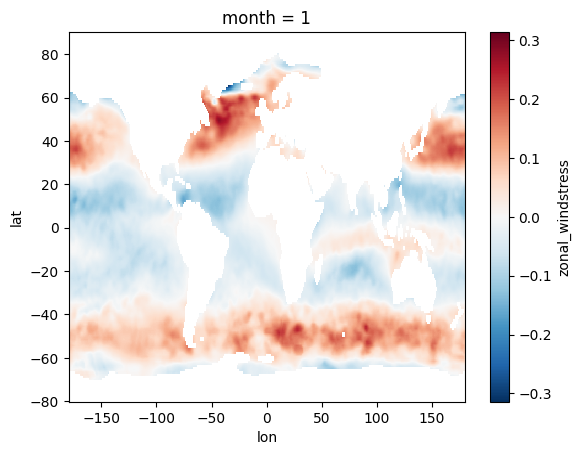

In [12]:
lats = loadmat("./atae.mat").get("lat").T[0]
lons = loadmat("./atae.mat").get("lon").T[0]
months = np.arange(1,13)
windstress = xr.Dataset(
    data_vars=dict(
        zonal_windstress=(["LAT","LONG","month"], loadmat("./atae.mat").get("atae")),
        meridional_windstress=(["LAT","LONG","month"], loadmat("./atae.mat").get("atae")),
        ),
    coords=dict(
        lat=("LAT", lats),
        lon=("LONG", lons),
        month=("month", months),
    ),
).swap_dims(dict(LAT="lat", LONG="lon")).sortby("lon")
windstress = deg360to180(windstress, "lon")
windstress_interp = windstress.interp(coords=dict(lat=mimoc.lat, lon=mimoc.lon))
windstress_interp.zonal_windstress.isel(month=0).plot()

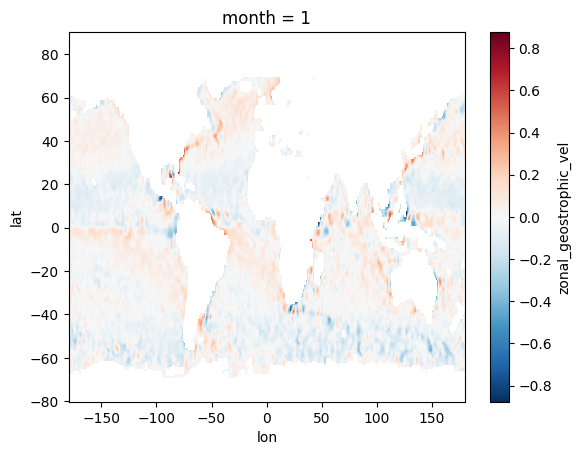

In [13]:
lats = loadmat("./Drifter_climatology.mat").get("lat").T[0]
lons = loadmat("./Drifter_climatology.mat").get("lon").T[0]
months = np.arange(1,13)
geostrophic_velocity = xr.Dataset(
    data_vars=dict(
        zonal_geostrophic_vel=(["LAT","LONG","month"], loadmat("./Drifter_climatology.mat").get("iV_g")),
        meridional_geostrophic_vel=(["LAT","LONG","month"], loadmat("./Drifter_climatology.mat").get("iU_g")),
        ),
    coords=dict(
        lat=("LAT", lats),
        lon=("LONG", lons),
        month=("month", months),
    ),
).swap_dims(dict(LAT="lat", LONG="lon")).sortby("lon")
geostrophic_velocity = deg360to180(geostrophic_velocity, "lon")
geostrophic_velocity_interp = geostrophic_velocity.interp(coords=dict(lat=mimoc.lat, lon=mimoc.lon))

geostrophic_velocity_interp.zonal_geostrophic_vel.isel(month=0).plot()

In [14]:
ds = mimoc.copy()
for var in windstress_interp :
    ds[var] = windstress_interp[var]

for var in geostrophic_velocity_interp :
    ds[var] = geostrophic_velocity_interp[var]
ds

<xarray.Dataset> Size: 130MB
Dimensions:                     (month: 12, lat: 341, lon: 720)
Coordinates:
  * month                       (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * lat                         (lat) float32 1kB -80.0 -79.5 ... 89.5 90.0
  * lon                         (lon) float32 3kB -179.5 -179.0 ... 179.5 180.0
Data variables:
    salinity_ML                 (month, lat, lon) float32 12MB dask.array<chunksize=(1, 341, 720), meta=np.ndarray>
    pot_temp_ML                 (month, lat, lon) float32 12MB dask.array<chunksize=(1, 341, 720), meta=np.ndarray>
    MLD                         (month, lat, lon) float32 12MB dask.array<chunksize=(1, 341, 720), meta=np.ndarray>
    zonal_windstress            (lat, lon, month) float64 24MB nan nan ... nan
    meridional_windstress       (lat, lon, month) float64 24MB nan nan ... nan
    zonal_geostrophic_vel       (lat, lon, month) float64 24MB nan nan ... nan
    meridional_geostrophic_vel  (lat, lon, month) float64 24MB nan nan ... nan

## Ekman Pumping

In [15]:
earth_rotation_rate = 2*np.pi/(24*60*60)
earth_rotation_rate

7.27220521664304e-05

In [16]:
ds["coriolis_parameter"] = 2*earth_rotation_rate*np.deg2rad(ds.lat).assign_attrs(dict(long_name="Coriolis Parameter"))
ds["con_temp_ML"] = gsw.conversions.CT_from_pt(ds.salinity_ML, ds.pot_temp_ML).assign_attrs(dict(long_name="Conservative Temperature in the Mixed Layer"))
ds["density"] = gsw.density.rho(ds.salinity_ML, ds.con_temp_ML, 0).assign_attrs(dict(long_name="Density in the Mixed Layer"))

In [17]:
ds["meridional_ekman_transport"] = ds.zonal_windstress / ds.coriolis_parameter
ds["zonal_ekman_transport"] = -ds.meridional_windstress / ds.coriolis_parameter

/home/lisa/Documents/THC/Thermohaline-Circulation/.venv/lib/python3.13/site-packages/dask/_task_spec.py:759: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)


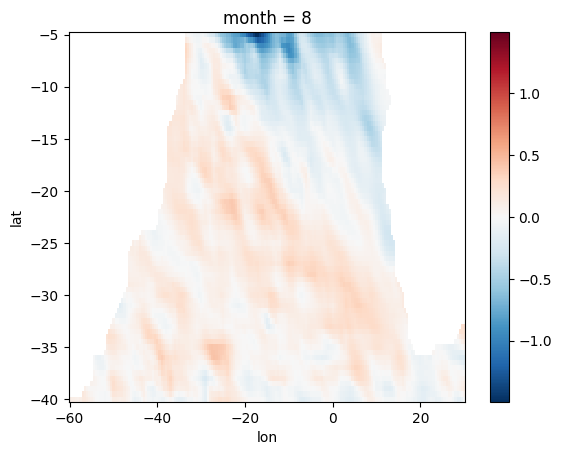

In [18]:
(
    (
        1/(ds.density *ds.coriolis_parameter)
    ) * 
    (
        ds.zonal_windstress.differentiate("lat") +
        ds.meridional_windstress.differentiate("lon")
    )
).sel(month=8, lon=slice(-60,30), lat=slice(-40, -5)).plot()


In [19]:
ds["ekman_pumping"] = (
    (1/(ds.density)) *
    (
        (ds.meridional_windstress).differentiate("lon") -
        (ds.zonal_windstress / ds.coriolis_parameter).differentiate("lat")
    )
).assign_attrs(
    dict(
        long_name="ekman pumping"
    )
    )

In [20]:
ds["gradient_MLD_y_times_mer_geost_vel"] = (
        ds.meridional_geostrophic_vel * 
        ds.MLD.differentiate("lat")
    ).assign_attrs(dict(long_name="scalarproduct of meridional geostrophic velocity and gradient of MLD in lat"))

ds["gradient_MLD_x_times_mer_geost_vel"] = (
        ds.meridional_geostrophic_vel * 
        ds.MLD.differentiate("lon")
    ).assign_attrs(dict(long_name="scalarproduct of meridional geostrophic velocity and gradient of MLD in lon"))

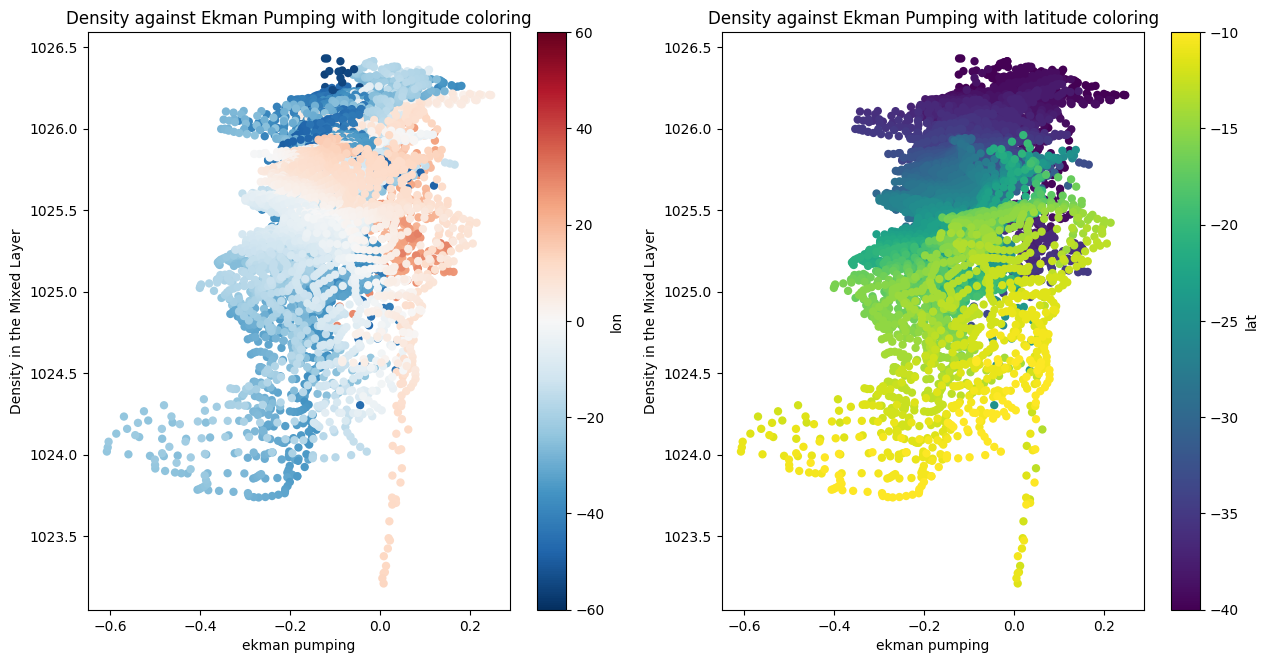

In [21]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(15,7.5))
ds.sel(month=8, lon=slice(-60,30), lat=slice(-40, -10)).plot.scatter(
    x="ekman_pumping", y="density",
    hue="lon", lw=0,
    ax=ax0
)
ds.sel(month=8, lon=slice(-60,30), lat=slice(-40, -10)).plot.scatter(
    x="ekman_pumping", y="density",
    hue="lat", lw=0,
    ax=ax1
)
ax0.set_title("Density against Ekman Pumping with longitude coloring")
ax1.set_title("Density against Ekman Pumping with latitude coloring")
plt.show()

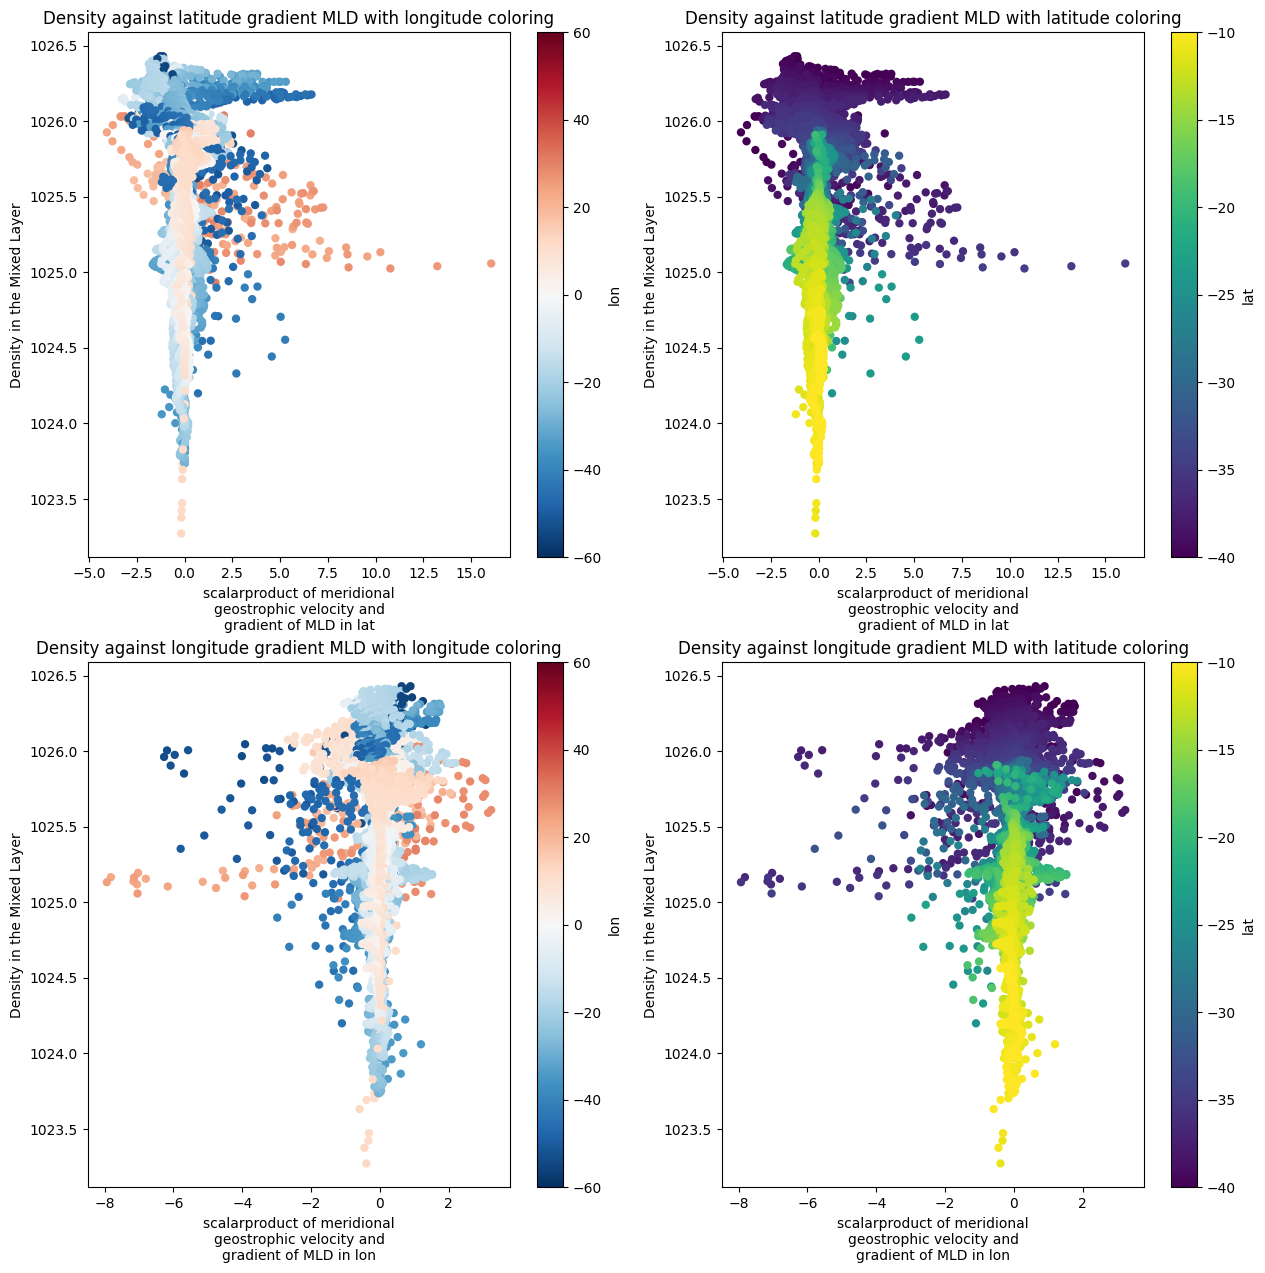

In [22]:
fig, ((ax00, ax01), (ax10, ax11)) = plt.subplots(2,2, figsize=(15,15))
ds.sel(month=8, lon=slice(-60,30), lat=slice(-40, -10)).plot.scatter(
    x="gradient_MLD_y_times_mer_geost_vel", y="density",
    hue="lon", lw=0,
    ax=ax00,
)
ds.sel(month=8, lon=slice(-60,30), lat=slice(-40, -10)).plot.scatter(
    x="gradient_MLD_y_times_mer_geost_vel", y="density",
    hue="lat", lw=0,
    ax=ax01,
)
ds.sel(month=8, lon=slice(-60,30), lat=slice(-40, -10)).plot.scatter(
    x="gradient_MLD_x_times_mer_geost_vel", y="density",
    hue="lon", lw=0,
    ax=ax10
)
ds.sel(month=8, lon=slice(-60,30), lat=slice(-40, -10)).plot.scatter(
    x="gradient_MLD_x_times_mer_geost_vel", y="density",
    hue="lat", lw=0,
    ax=ax11
)
ax00.set_title("Density against latitude gradient MLD with longitude coloring")
ax01.set_title("Density against latitude gradient MLD with latitude coloring")
ax10.set_title("Density against longitude gradient MLD with longitude coloring")
ax11.set_title("Density against longitude gradient MLD with latitude coloring")
plt.show()



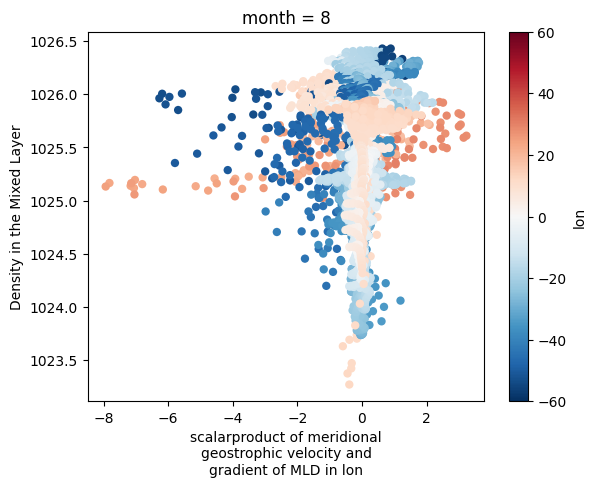

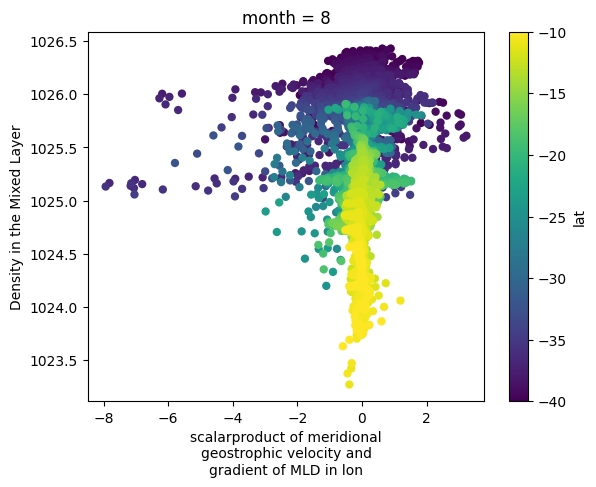

In [23]:
ds.sel(month=8, lon=slice(-60,30), lat=slice(-40, -10)).plot.scatter(
    x="gradient_MLD_x_times_mer_geost_vel", y="density",
    hue="lon", lw=0,
)
plt.show()
ds.sel(month=8, lon=slice(-60,30), lat=slice(-40, -10)).plot.scatter(
    x="gradient_MLD_x_times_mer_geost_vel", y="density",
    hue="lat", lw=0,
)


## Exercise 2

Using latitude 10.50° for '10°N'
Using latitude -9.50° for '10°S'
Mean Ekman transport at 10N: 0.227 Sv/deg
Mean Ekman transport at 10S: -0.208 Sv/deg


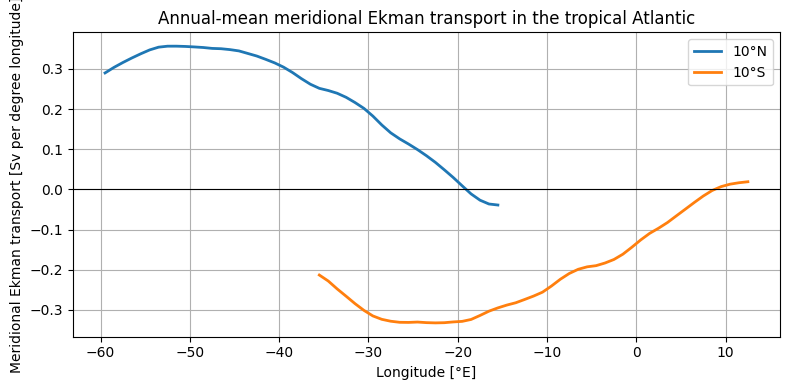

In [25]:
# Exercise 2: Ekman transport in the tropical Atlantic

rho0 = 1025.0          # reference density [kg m^-3]
R_earth = 6.371e6      # Earth radius [m]

# Coriolis parameter f = 2 * Omega * sin(phi)
coriolis = 2 * earth_rotation_rate * np.sin(np.deg2rad(windstress["lat"]))
windstress["coriolis_parameter"] = coriolis.assign_attrs(
    dict(long_name="Coriolis parameter", units="s^-1")
)

# Annual mean wind stress
windstress_annual = windstress.mean(dim="month", skipna=True)

# Meridional Ekman transport per unit width M_Ey = -tau_x /(rho0 * f)
windstress_annual["meridional_ekman_transport"] = -(
    windstress_annual.zonal_windstress
    / (rho0 * windstress_annual.coriolis_parameter)
)
windstress_annual.meridional_ekman_transport.attrs.update(
    dict(long_name="Meridional Ekman transport per unit width",
         units="m^2 s^-1")
)

# Restrict to Atlantic sector
atlantic = windstress_annual.sel(lon=slice(-60, 30))

# Grid rows closest to 10°N and 10°S
ekman_10N = atlantic.meridional_ekman_transport.sel(lat=10, method="nearest")
ekman_10S = atlantic.meridional_ekman_transport.sel(lat=-10, method="nearest")

lat_10N = float(ekman_10N.lat)
lat_10S = float(ekman_10S.lat)

print(f"Using latitude {lat_10N:.2f}° for '10°N'")
print(f"Using latitude {lat_10S:.2f}° for '10°S'")

# Convert to transport in Sv per degree longitude
dlambda_rad = np.deg2rad(1.0)

dx_10N = R_earth * np.cos(np.deg2rad(lat_10N)) * dlambda_rad   # [m per 1° lon]
dx_10S = R_earth * np.cos(np.deg2rad(lat_10S)) * dlambda_rad   # [m per 1° lon]

T_10N_Sv = ekman_10N * dx_10N / 1e6        # [Sv per degree longitude]
T_10S_Sv = ekman_10S * dx_10S / 1e6        # [Sv per degree longitude]

print(f"Mean Ekman transport at 10N: {float(T_10N_Sv.mean()):.3f} Sv/deg")
print(f"Mean Ekman transport at 10S: {float(T_10S_Sv.mean()):.3f} Sv/deg")

# Plot meridional Ekman transport vs longitude
plt.figure(figsize=(8, 4))
plt.plot(T_10N_Sv["lon"], T_10N_Sv, label="10°N", linewidth=2)
plt.plot(T_10S_Sv["lon"], T_10S_Sv, label="10°S", linewidth=2)
plt.axhline(0, color="k", linewidth=0.8)
plt.xlabel("Longitude [°E]")
plt.ylabel("Meridional Ekman transport [Sv per degree longitude]")
plt.title("Annual-mean meridional Ekman transport in the tropical Atlantic")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
